Assignment 1 - analysis of movie reviews
===

*Due: November 29 2022*

In this assignment you will use web scraping tools to extract the reviews of 2 movies - Dune and Interstellar  - from Rotten Tomatoes.

You will save these reviews as text - strings - in a database that you will save as a CSV file.

After obtaining a dataset of Dune and Interstellar reviews, for each movie you will obtain:

- Wordclouds

- Word Frequency Barplots with the 20 most-frequent words: frequency as Y-axis and words as X-axis

- Sentiment scores for each movie using AFINN

## Define function to download reviews

Code take from [this](https://stackoverflow.com/questions/69963743/scraping-all-reviews-of-a-movie-from-rotten-tomato-using-soup) stackoverflow question:

In [1]:
import jupyter_black

jupyter_black.load()

In [88]:
import pandas as pd
import requests
import re
import time
import html
import regex as re
import json, os
import matplotlib.pyplot as plt
import contractions
from wordcloud import WordCloud


headers = {
    "Referer": "https://www.rottentomatoes.com/m/notebook/reviews?type=user",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.108 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
}

s = requests.Session()


def get_reviews(url):
    r = requests.get(url)
    movie_id = re.findall(r'(?<=movieId":")(.*)(?=","type)', r.text)[0]

    api_url = f"https://www.rottentomatoes.com/napi/movie/{movie_id}/criticsReviews/all"  # use reviews/userfor user reviews

    payload = {
        "direction": "next",
        "endCursor": "",
        "startCursor": "",
    }

    review_data = []

    while True:
        r = s.get(api_url, headers=headers, params=payload)
        data = r.json()

        # unescape html
        for i, review in enumerate(data["reviews"]):
            data["reviews"][i]["quotes"] = html.unescape(review["quote"])

        if not data["pageInfo"]["hasNextPage"]:
            break

        payload["endCursor"] = data["pageInfo"]["endCursor"]
        payload["startCursor"] = (
            data["pageInfo"]["startCursor"]
            if data["pageInfo"].get("startCursor")
            else ""
        )

        review_data.extend(data["reviews"])
        time.sleep(1)

    return review_data


def plot_wordcloud(df, name="", max_words=20):
    # One long string
    word_string = " ".join(list(df.quotes))
    word_string = word_string.lower()
    word_string = contractions.fix(word_string)
    word_string = re.sub(",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string)

    ## here we set the parameters for wordcloud function
    wordcloud = WordCloud(
        collocations=False,
        max_font_size=100,
        width=800,
        height=600,
        colormap="Set2",
        max_words=max_words,
        background_color="white",
    ).generate(word_string)

    if name != "":
        name = "_" + name + "_"

    ## these are matplot lib commants to show the image, and save as a figure (see it appear in the files manu on the left)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud" + name + ".png")
    plt.show()


def create_df_wordcount(df):
    """
    Returns dataframe with word count
    """

    # One long string
    word_string = " ".join(list(df.quotes))

    # To lower case
    word_string = word_string.lower()

    # remove contractions
    word_string = contractions.fix(word_string)

    # Replace dots, exclamation marks and so on ... with space
    word_string = re.sub(",|\.|--|!|\?|:|\"|\(|\)|\[|\]|\s-\s|/|'s|'", " ", word_string)

    # Split into list of words

    word_list = word_string.split(" ")

    word_set = set(word_list)

    # Create dataframe with word and count

    word_count = [
        (word, word_list.count(word)) for word in list(word_set) if word != ""
    ]

    df_word_count = (
        pd.DataFrame(word_count, columns=["word", "count"])
        .sort_values("count", ascending=False)
        .reset_index(drop=True)
    )

    return df_word_count

## Download reviews

In [96]:
%%time

# the movies you are interested in
movies = ["interstellar_2014", "dune_2021", "shining", "one_flew_over_the_cuckoos_nest"]


data_path = "data/01_data.json"

if os.path.exists(data_path):

    with open(data_path) as fp:
        data = json.load(fp)
        missing = set(movies) - set(data.keys())
        if len(missing) > 0:
            print("Downloading:", ", ".join(list(missing)), "\n")

            for movie in missing:
                data[movie] = get_reviews(
                    "https://www.rottentomatoes.com/m/" + movie + "/reviews"
                )

            # save to disk
            with open(data_path, "w", encoding="utf8") as fp:
                json.dump(data, fp)

        else:
            print("It's all there!\n")


else:
    data = {}
    print("Downloading reviews:\n")
    for movie in movies:
        print(movie, "...")
        data[movie] = get_reviews(
            "https://www.rottentomatoes.com/m/" + movie + "/reviews"
        )

    # save to disk
    with open(data_path, "w", encoding="utf8") as fp:
        json.dump(data, fp)

It's all there!

CPU times: user 12.8 ms, sys: 4 µs, total: 12.8 ms
Wall time: 12 ms


### Interstellar

#### Word clouds

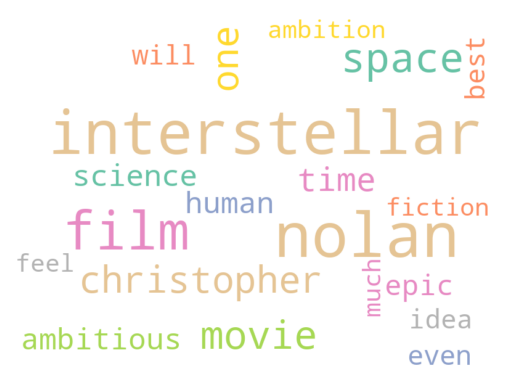

In [90]:
name = "interstellar_2014"

df = pd.json_normalize(data[name])
plot_wordcloud(df_interstellar, name)

#### Plot word frequency

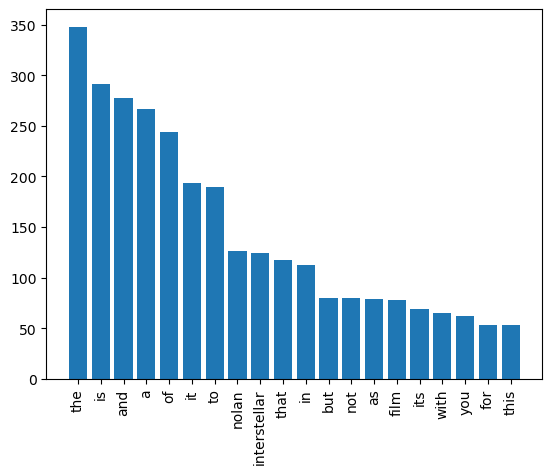

In [92]:
df_word_count = create_df_wordcount(df)

# limit to the 20 most frequent words
df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

#### Sentiment score

In [93]:
#
#
#

### Dune

#### Word clouds

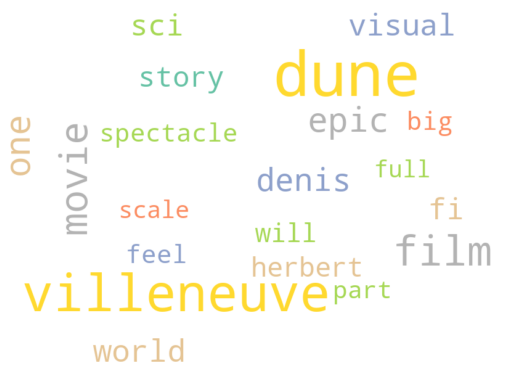

In [94]:
name = "dune_2021"

df = pd.json_normalize(data[name])
plot_wordcloud(df, name)

#### Plot word frequency

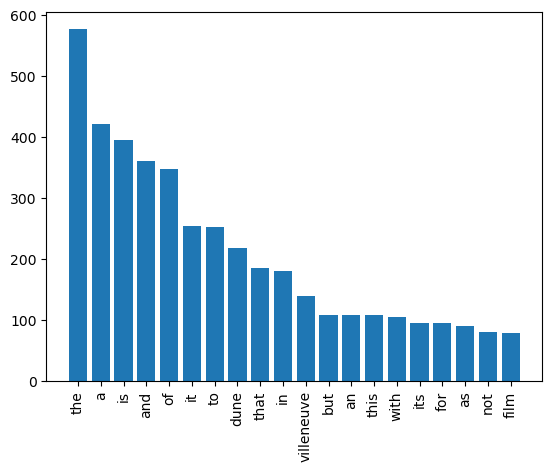

In [95]:
df_word_count = create_df_wordcount(df)

# limit to the 20 most frequent words

df_pl = df_word_count.iloc[0:20, :]

plt.bar(x=df_pl["word"], height=df_pl["count"])
plt.xticks(rotation=90);

#### Sentiment score

In [14]:
#
#
#